In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter2_"

loss_list = []
normalized_loss_list = []

print(datetime.datetime.now())

2023-06-11 19:11:07.914446


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter1")

dec: h_dim 48
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter1 ckpt_iwvi_pendulum_policy_optimization_iter1
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-3.7638)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(3.8969)
penalty_target_min tensor(-6.1621) penalty_target_max tensor(40.7745)
train_loss:  -5.674221944999695
valid_loss:  -4.697155633401871
h_min_tilde -6.1621046 ell_tilde -5.478808682680129 kappa_tilde 0.0012097498724169457
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter1
train_loss:  -2.0602355510473256
valid_loss:  -1.7730969016075133
weight_alpha 1.0 h_min_tilde -6.1621046 ell_tilde -2.0028078211593634 kappa_tilde 0.000490331782918506


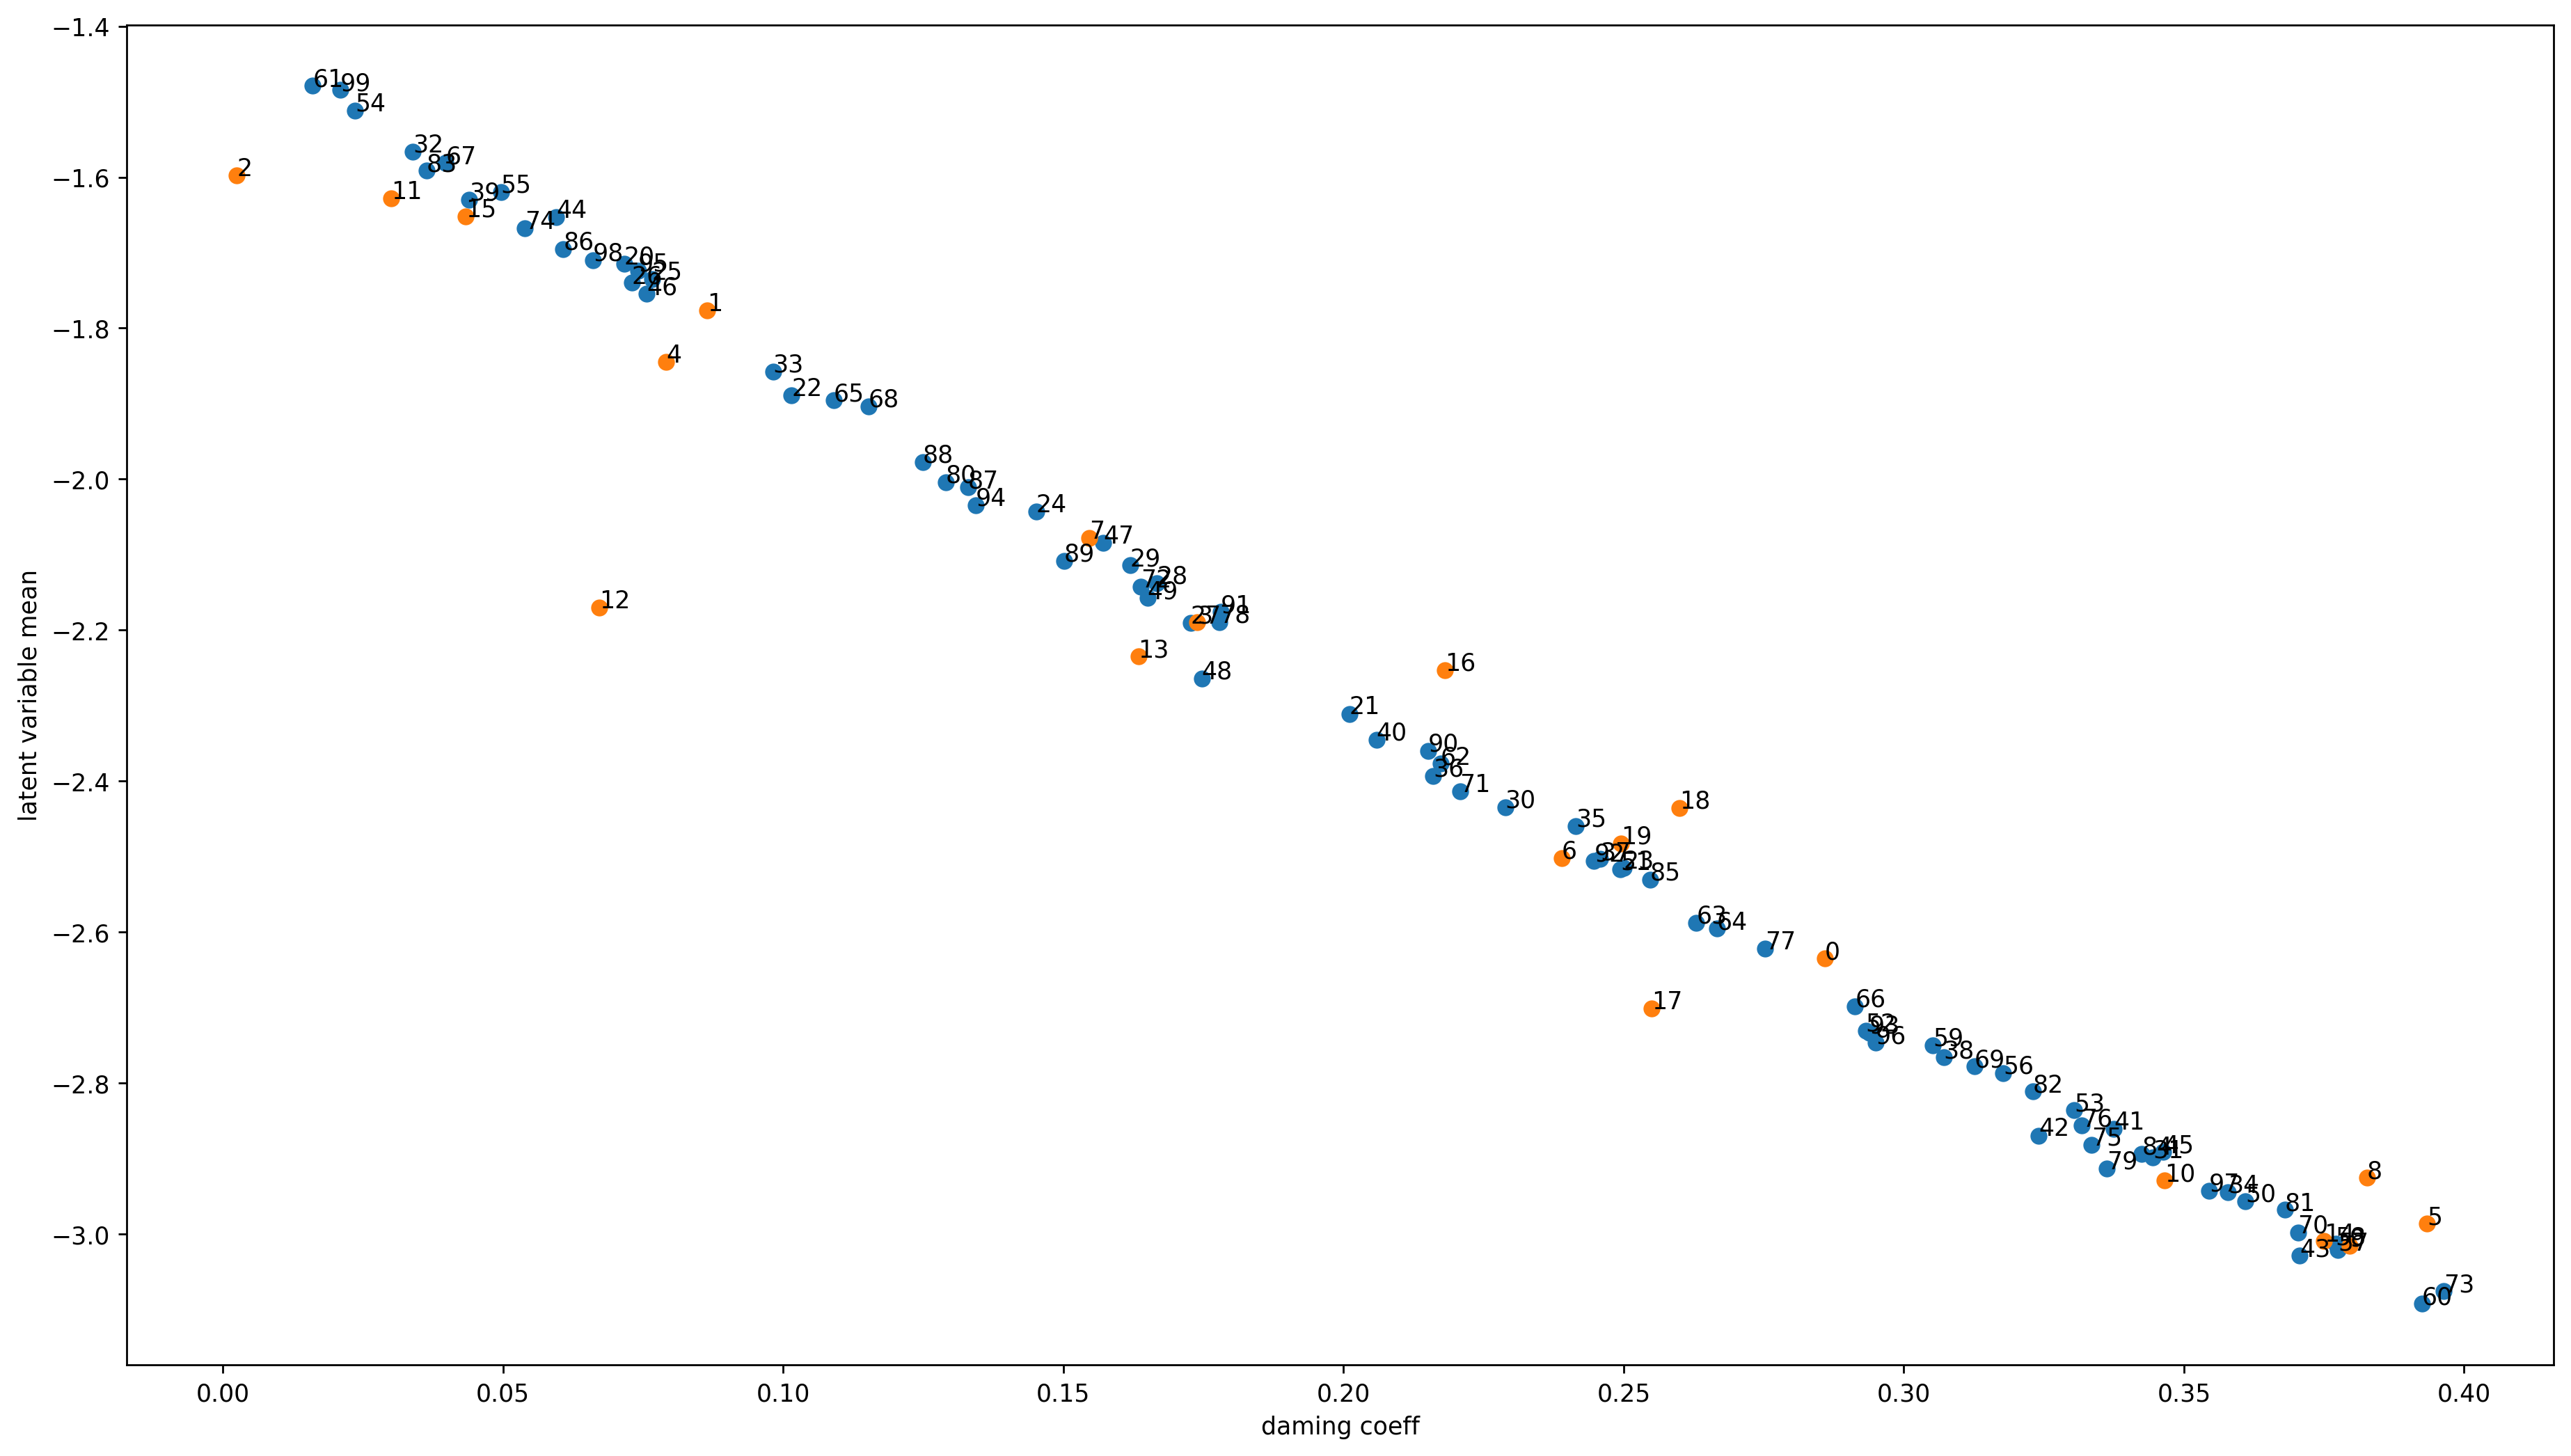

[0.2859264  0.0864358  0.0024921  0.17391661 0.07907403 0.39336027
 0.23893358 0.15462851 0.38266119 0.37959092]
[0.34651572 0.02997943 0.06718887 0.16337754 0.37502863 0.04327735
 0.21808106 0.2550441  0.25992204 0.24956645]
[0.07158956 0.20101322 0.10147186 0.24997234 0.14514144 0.07657856
 0.07297816 0.17272883 0.16671052 0.16193009]
[0.22885551 0.34440572 0.03386464 0.09818148 0.35786052 0.2414254
 0.21602989 0.24582514 0.30710321 0.04392725]
[0.20586148 0.3374828  0.32405777 0.37068828 0.05949074 0.34630997
 0.0756103  0.15711247 0.17470652 0.16498888]
[0.36096874 0.24942754 0.29319949 0.33040915 0.02355204 0.04960585
 0.31776933 0.377519   0.37703434 0.30519746]
[0.39248397 0.01603645 0.21731613 0.26299385 0.26662336 0.10898858
 0.29130778 0.03973111 0.11521473 0.31261245]
[0.37032344 0.22077058 0.16383656 0.39631873 0.05390104 0.33351255
 0.33176718 0.27528851 0.17781627 0.33618643]
[0.12902999 0.36799494 0.32301958 0.03636422 0.34247351 0.25473947
 0.06075424 0.13299807 0.12488

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 3.3177530765533447

 2 3.1534535884857178

 3 3.1483895778656006

 4 3.1700055599212646

 5 3.208754777908325

 6 2.8856306076049805

 7 3.0938239097595215

 8 3.136451482772827

 9 3.4747297763824463

 10 3.0162034034729004

 11 3.152740716934204

 12 3.0572614669799805

 13 3.1893739700317383

 14 3.117741584777832

 15 3.1777706146240234

 16 3.1260006427764893

 17 3.1175014972686768

 18 3.1258842945098877

 19 3.435497999191284

 20 3.2116565704345703

 21 3.1480894088745117

 22 3.3002328872680664

 23 3.192429304122925

 24 3.1879043579101562

 25 3.156996488571167

 26 3.168318748474121

 27 3.1775310039520264

 28 3.2134268283843994

 29 3.187453508377075

 30 3.0699987411499023

 31 3.0866804122924805

 32 3.083250045776367

 33 3.1219472885131836

 34 3.134122371673584

 35 3.3066980838775635

 36 3.3617396354675293

 37 3.13169002532959

 38 3.0244081020355225

 39 3.1154937744140625

 40 3.17391037940979

 41 3.083484172821045

 42 3.069697141647339

 43 3.09965848922

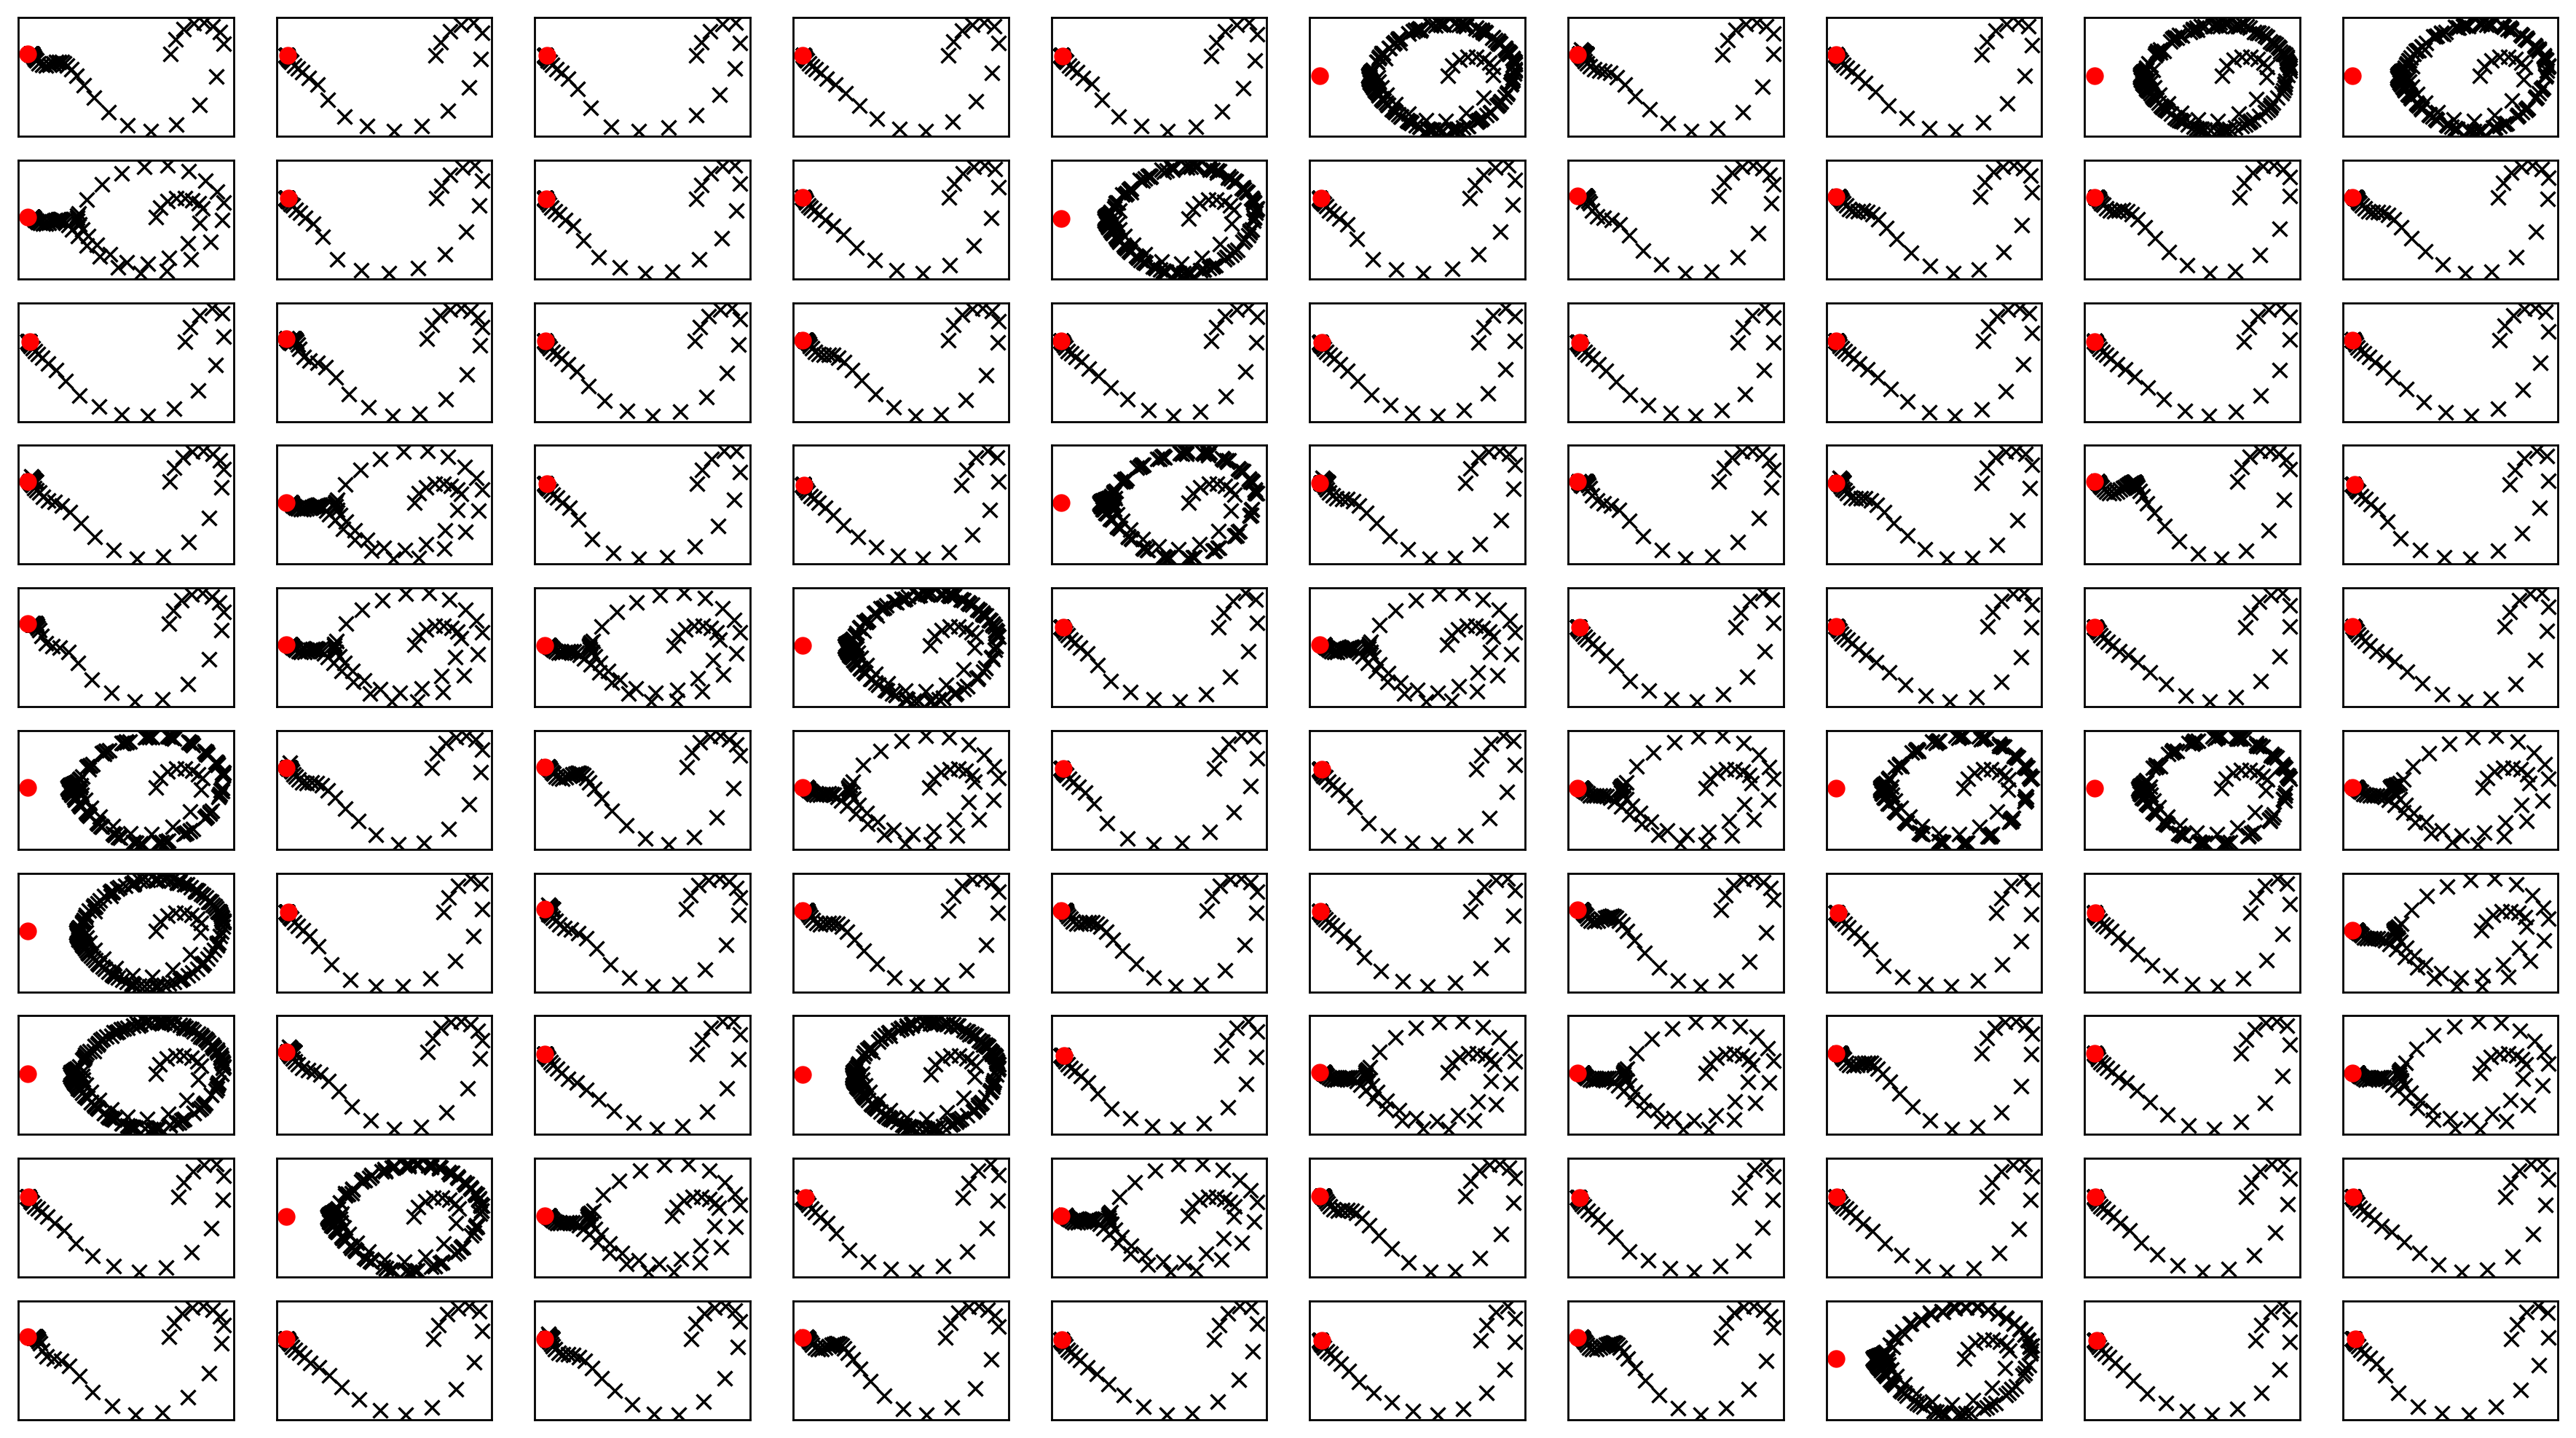

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.show()

In [8]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 4.76837158203125e-07

 1 3.22593092918396

 2 3.1037631034851074

 3 3.18664813041687

 4 4.306066036224365

 5 6.863296747207642

 6 6.7936110496521

 7 7.122172594070435

 8 6.821920871734619

 9 6.793955326080322

 10 6.803000450134277

 11 6.8589301109313965

 12 6.742487668991089

 13 6.642051935195923

 14 6.982710123062134

 15 6.578722715377808

 16 6.839752912521362

 17 6.859228134155273

 18 7.135889530181885

 19 7.111050844192505

 20 6.977818012237549

 21 6.901405334472656

 22 6.972368240356445

 23 6.781540632247925

 24 6.923399925231934

 25 6.901334285736084

 26 6.663166284561157

 27 6.815345048904419

 28 6.946009874343872

 29 6.667372465133667

 30 7.035671710968018

 31 6.826626777648926

 32 6.745787620544434

 33 6.763498544692993

 34 6.78593373298645

 35 6.7584123611450195

 36 6.660818338394165

 37 6.896365642547607

 38 6.759423732757568

 39 6.909657001495361

 40 6.828677177429199

 41 6.774170875549316

 42 6.873885154724121

 43 6.8900613784790

実環境方策rollout vs Sim環境方策rollout


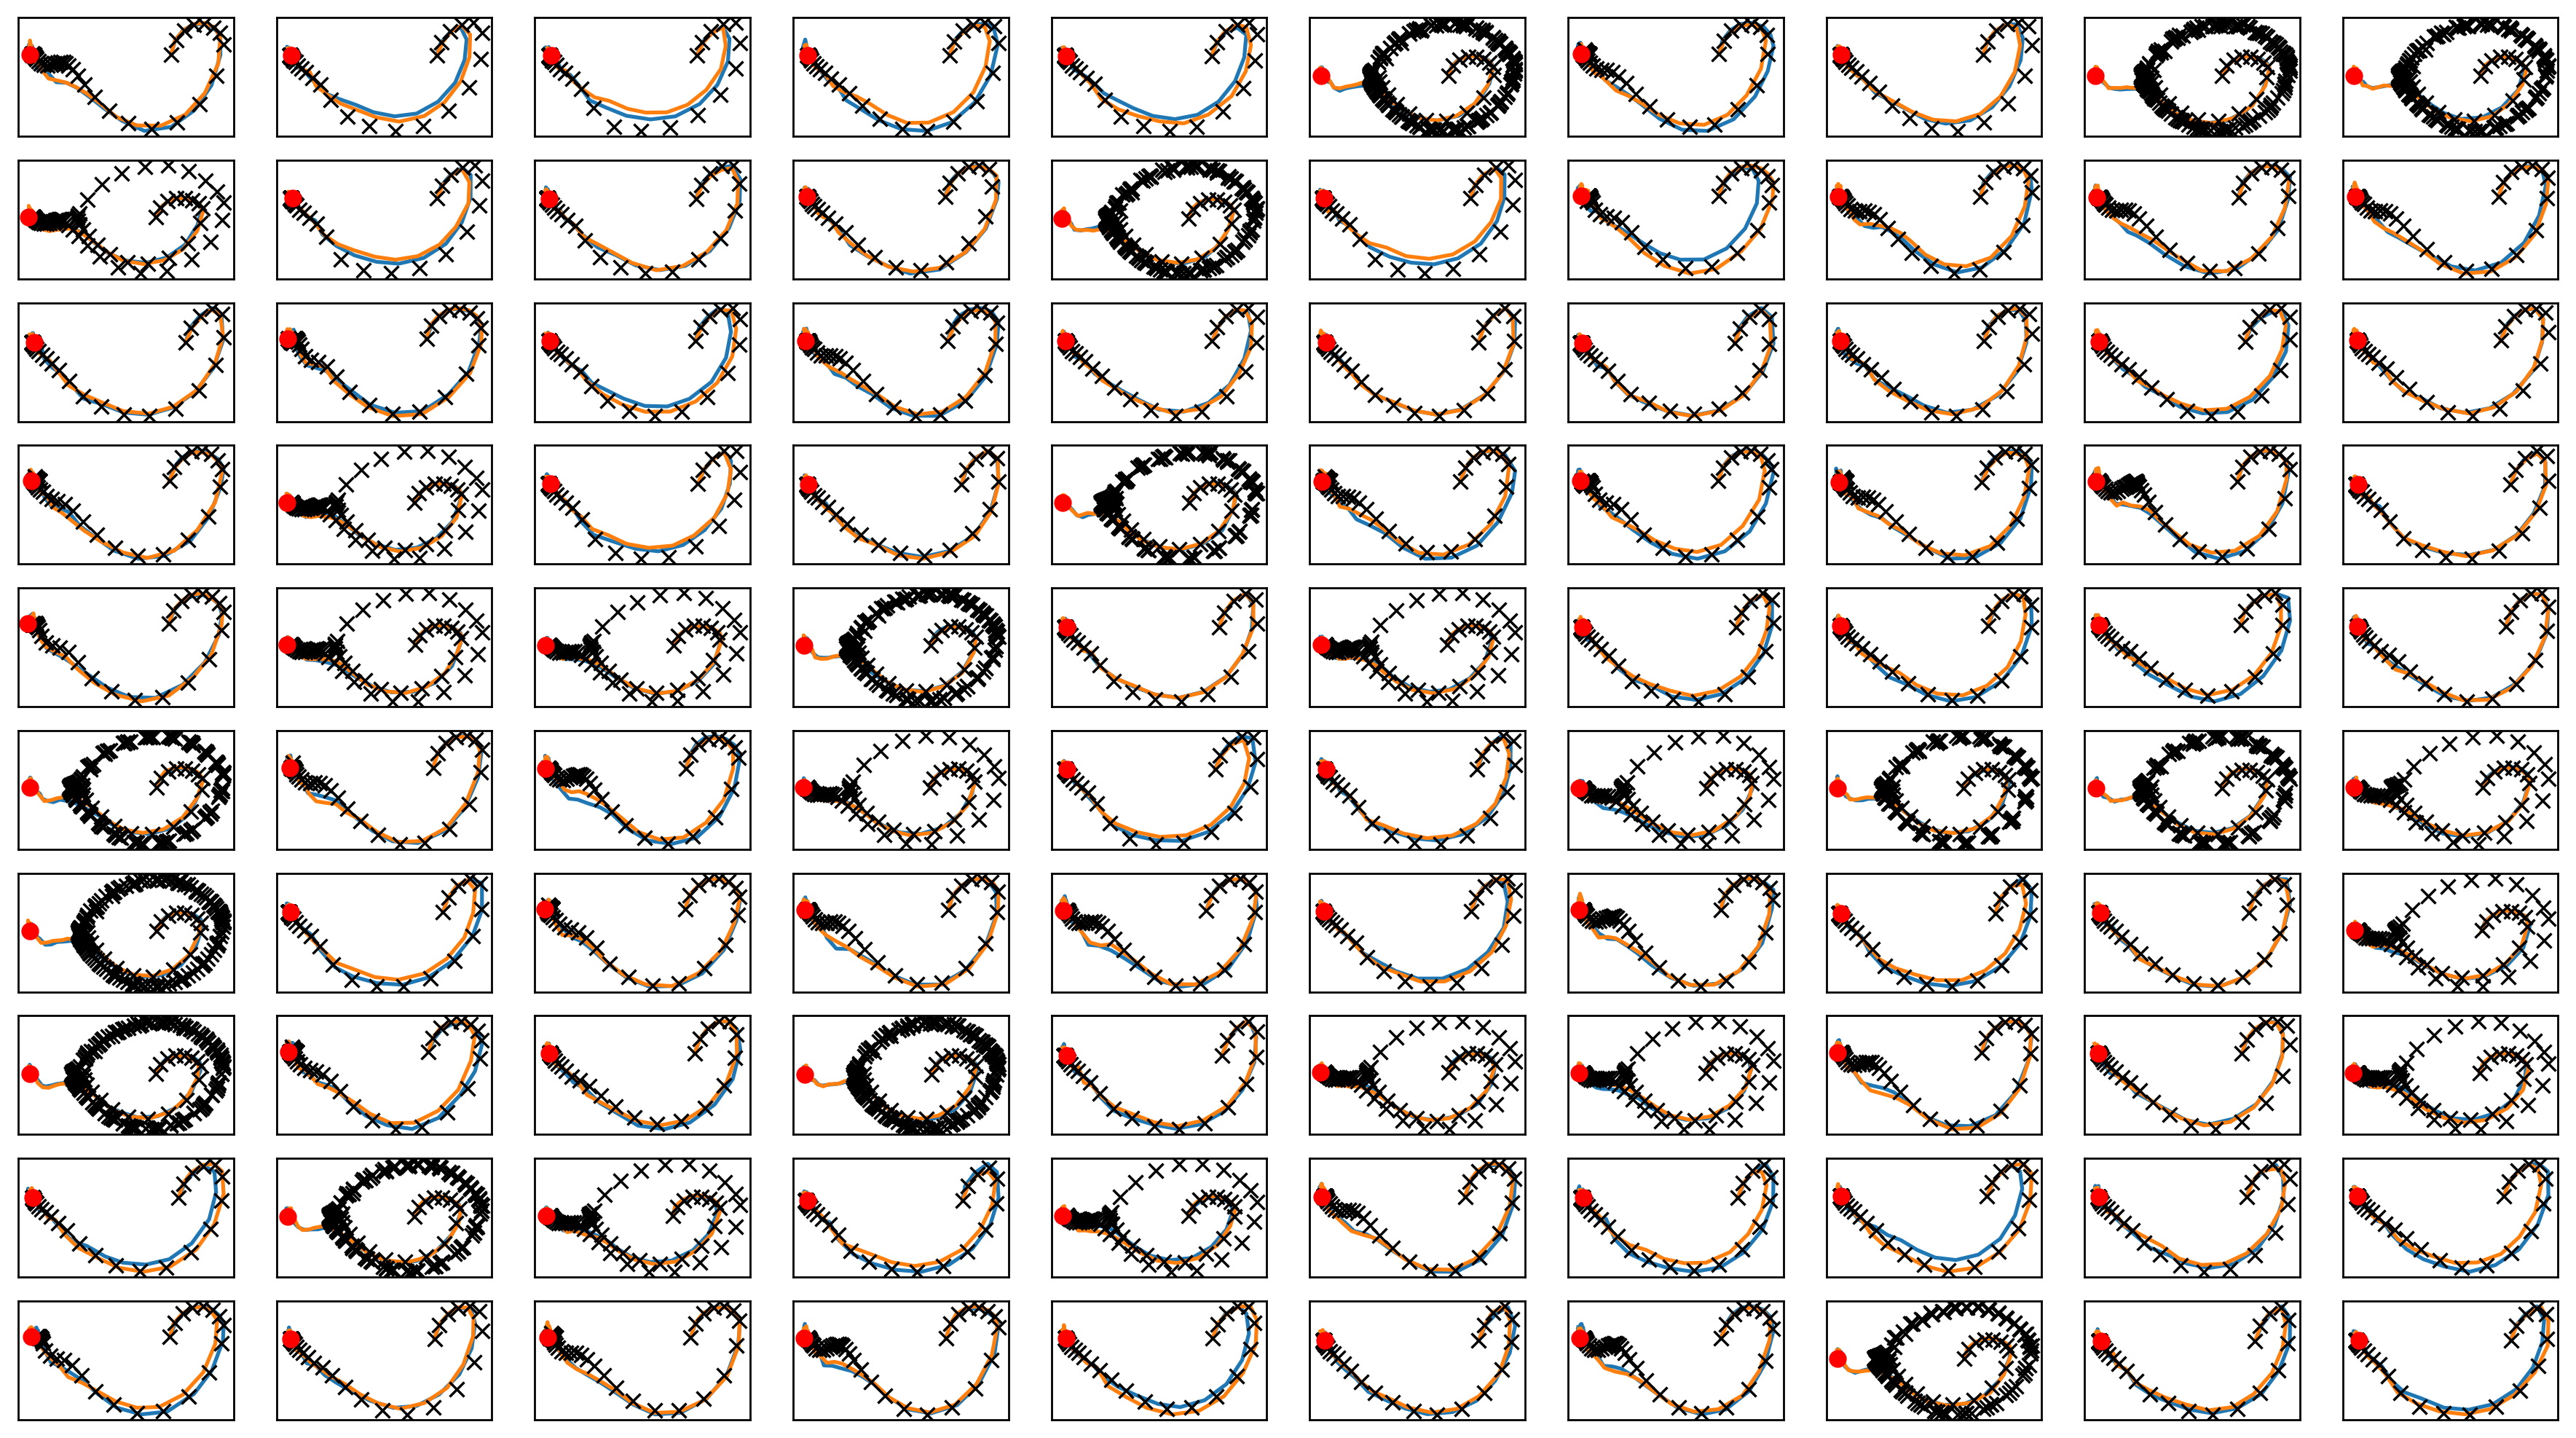

In [9]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [10]:
print(datetime.datetime.now())

2023-06-11 19:33:57.973978
